In [1]:
op=open("D:\WebDevelopment\langchain\openAPIKEY.txt","r")
f = open("D:\WebDevelopment\langchain\HuggingFaceAPI.txt", "r")
gs=open("D:\WebDevelopment\langchain\googlesearchAPIkey.txt","r")
g_cse=open("D:\WebDevelopment\langchain\google_cse_id.txt")
ser_api=open("D:\WebDevelopment\langchain\ser.txt","r")
ta_S=open("tavily_search.txt","r") 
API_KEY=f.readline()
Google_searchKey=gs.readline()
Google_CSE=g_cse.readline()
OpenAPI_KEY=op.readline()
seri_api=ser_api.readline()
tavily_search=ta_S.readline()
f.close()
gs.close()
g_cse.close()
op.close()
ser_api.close()
ta_S.close()

In [2]:
import os
os.environ["GOOGLE_CSE_ID"] = Google_CSE
os.environ["GOOGLE_API_KEY"] = Google_searchKey
os.environ['OPENAI_API_KEY']=OpenAPI_KEY
os.environ["SERPAPI_API_KEY"] = seri_api
os.environ["TAVILY_API_KEY"] =tavily_search

In [3]:
from langgraph.graph import StateGraph,END
from typing import TypedDict,Annotated,List
import operator
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_core.messages import AnyMessage,SystemMessage,HumanMessage,AIMessage,ChatMessage

memory=SqliteSaver.from_conn_string(":memory:")

In [4]:
class AgentState(TypedDict):
    task:str
    plan:str
    draft:str
    critique:str
    content:List[str]
    revision_number: int
    max_revisions:int

In [5]:
from langchain_openai import ChatOpenAI
model=ChatOpenAI(model='gpt-3.5-turbo',temperature=0)

In [6]:
PLAN_PROMPT = """You are an expert writer tasked with writing a high level outline of an essay. \
Write such an outline for the user provided topic. Give an outline of the essay along with any relevant notes \
or instructions for the sections."""

In [7]:
WRITER_PROMPT = """You are an essay assistant tasked with writing excellent 5-paragraph essays.\
Generate the best essay possible for the user's request and the initial outline. \
If the user provides critique, respond with a revised version of your previous attempts. \
Utilize all the information below as needed: 

------

{content}"""

In [8]:
REFLECTION_PROMPT = """You are a teacher grading an essay submission. \
Generate critique and recommendations for the user's submission. \
Provide detailed recommendations, including requests for length, depth, style, etc."""

In [9]:
RESEARCH_PLAN_PROMPT = """You are a researcher charged with providing information that can \
be used when writing the following essay. Generate a list of search queries that will gather \
any relevant information. Only generate 5 queries max."""


In [10]:
RESEARCH_CRITIQUE_PROMPT = """You are a researcher charged with providing information that can \
be used when making any requested revisions (as outlined below). \
Generate a list of search queries that will gather any relevant information. Only generate 5 queries max."""


In [11]:
from langchain_core.pydantic_v1 import BaseModel
class Queries(BaseModel):
    queries:List[str]

In [12]:
from tavily import TavilyClient
import os
tavily = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])

In [13]:
def plan_node(state:AgentState):
    messages=[
        SystemMessage(content=PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ]
    response=model.invoke(messages)
    return {"plan":response.content}

In [14]:
def research_plan_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [15]:
def generation_node(state: AgentState):
    content = "\n\n".join(state['content'] or [])
    user_message = HumanMessage(
        content=f"{state['task']}\n\nHere is my plan:\n\n{state['plan']}")
    messages = [
        SystemMessage(
            content=WRITER_PROMPT.format(content=content)
        ),
        user_message
        ]
    response = model.invoke(messages)
    return {
        "draft": response.content, 
        "revision_number": state.get("revision_number", 1) + 1
    }


In [16]:
def reflection_node(state: AgentState):
    messages = [
        SystemMessage(content=REFLECTION_PROMPT), 
        HumanMessage(content=state['draft'])
    ]
    response = model.invoke(messages)
    return {"critique": response.content}

In [17]:
def research_critique_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
        HumanMessage(content=state['critique'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=6)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [18]:
def should_continue(state):
    if state["revision_number"] > state["max_revisions"]:
        return END
    return "reflect"

In [19]:
builder=StateGraph(AgentState)

In [20]:
builder.add_node("planner", plan_node)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_node("research_plan", research_plan_node)
builder.add_node("research_critique", research_critique_node)

In [21]:
builder.set_entry_point("planner")

In [22]:
builder.add_conditional_edges(
    "generate",
    should_continue,
    {END:END,"reflect":"reflect"}
)

In [23]:
builder.add_edge("planner", "research_plan")
builder.add_edge("research_plan", "generate")

builder.add_edge("reflect", "research_critique")
builder.add_edge("research_critique", "generate")

In [24]:
graph=builder.compile(checkpointer=memory)

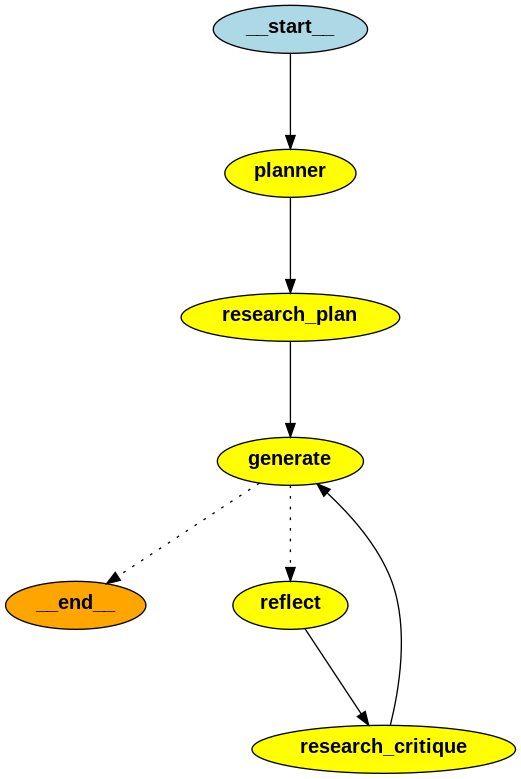

In [25]:
thread = {"configurable": {"thread_id": "1"}}
for s in graph.stream({
    'task': "what is the difference between langchain,langgraph,langserve and langsmith",
    "max_revisions": 2,
    "revision_number": 1,
}, thread):
    print(s)

{'planner': {'plan': 'I. Introduction\n    A. Brief overview of Langchain, Langgraph, Langserve, and Langsmith\n    B. Thesis statement: Exploring the differences between Langchain, Langgraph, Langserve, and Langsmith\n\nII. Langchain\n    A. Definition and purpose\n    B. Key features and functionalities\n    C. Use cases and examples\n\nIII. Langgraph\n    A. Definition and purpose\n    B. Key features and functionalities\n    C. Use cases and examples\n\nIV. Langserve\n    A. Definition and purpose\n    B. Key features and functionalities\n    C. Use cases and examples\n\nV. Langsmith\n    A. Definition and purpose\n    B. Key features and functionalities\n    C. Use cases and examples\n\nVI. Comparison\n    A. Contrasting the differences between Langchain, Langgraph, Langserve, and Langsmith\n    B. Highlighting unique aspects of each tool\n    C. Discussing potential overlaps or complementary functions\n\nVII. Conclusion\n    A. Recap of the key points discussed\n    B. Summary of